In [1]:
# code block for imports 
import pandas as pd 
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns

In [2]:
conn = sqlite3.connect('cs506MAPC.db')

## Display first 10 Providers 

In [3]:
qrystr ="SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"


#convert query results into dataframe
df_filtered_providers = pd.read_sql_query(qrystr, conn)
print(df_filtered_providers.head(10))

                     ProviderName     tractNum  MaxAdDown  MaxAdUp      town  \
0  MCI Communications Corporation  25023520100        0.0      0.0  ABINGTON   
1  MCI Communications Corporation  25023520201        0.0      0.0  ABINGTON   
2  MCI Communications Corporation  25023520202        0.0      0.0  ABINGTON   
3          Crown Castle Fiber LLC  25023520100        0.0      0.0  ABINGTON   
4          Crown Castle Fiber LLC  25023520201        0.0      0.0  ABINGTON   
5          Crown Castle Fiber LLC  25023520202        0.0      0.0  ABINGTON   
6                    ViaSat, Inc.  25023520100      100.0      3.0  ABINGTON   
7                    ViaSat, Inc.  25023520201      100.0      3.0  ABINGTON   
8                    ViaSat, Inc.  25023520202      100.0      3.0  ABINGTON   
9          U.S. TelePacific Corp.  25023520202        0.0      0.0  ABINGTON   

   Longitude  Latitude  
0     -70.96     42.12  
1     -70.96     42.12  
2     -70.96     42.12  
3     -70.96     42

## Non Zero Providers

In [4]:
qryStr2 = "SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_non_zero_providers = pd.read_sql_query(qryStr2, conn)
print(df_filtered_non_zero_providers.head(10))

                        ProviderName     tractNum  MaxAdDown  MaxAdUp  \
0                       ViaSat, Inc.  25023520100      100.0    3.000   
1                       ViaSat, Inc.  25023520201      100.0    3.000   
2                       ViaSat, Inc.  25023520202      100.0    3.000   
3  COMCAST CABLE COMMUNICATIONS, LLC  25023520100      987.0   35.000   
4  COMCAST CABLE COMMUNICATIONS, LLC  25023520201      987.0   35.000   
5  COMCAST CABLE COMMUNICATIONS, LLC  25023520202      987.0   35.000   
6           Verizon New England Inc.  25023520202      940.0  880.000   
7           Verizon New England Inc.  25023520202        5.0    0.768   
8           Verizon New England Inc.  25023520202       15.0    1.000   
9           Verizon New England Inc.  25023520202       10.0    1.000   

       town  Longitude  Latitude  
0  ABINGTON     -70.96     42.12  
1  ABINGTON     -70.96     42.12  
2  ABINGTON     -70.96     42.12  
3  ABINGTON     -70.96     42.12  
4  ABINGTON     -70.9

## Zero Providers

In [5]:
qryStr3 = "SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown = 0 AND MaxAdUp = 0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_zero_providers = pd.read_sql_query(qryStr3, conn)
print(df_filtered_zero_providers.head(10))

                        ProviderName     tractNum  MaxAdDown  MaxAdUp  \
0     MCI Communications Corporation  25023520100        0.0      0.0   
1     MCI Communications Corporation  25023520201        0.0      0.0   
2     MCI Communications Corporation  25023520202        0.0      0.0   
3             Crown Castle Fiber LLC  25023520100        0.0      0.0   
4             Crown Castle Fiber LLC  25023520201        0.0      0.0   
5             Crown Castle Fiber LLC  25023520202        0.0      0.0   
6             U.S. TelePacific Corp.  25023520202        0.0      0.0   
7  Broadview Networks Holdings, Inc.  25023520100        0.0      0.0   
8  COMCAST CABLE COMMUNICATIONS, LLC  25023520201        0.0      0.0   
9  COMCAST CABLE COMMUNICATIONS, LLC  25023520100        0.0      0.0   

       town  Longitude  Latitude  
0  ABINGTON     -70.96     42.12  
1  ABINGTON     -70.96     42.12  
2  ABINGTON     -70.96     42.12  
3  ABINGTON     -70.96     42.12  
4  ABINGTON     -70.9

## Max Providers Per Area

In [6]:
town_dict = {}
towns = df_filtered_zero_providers['town']
providers = df_filtered_zero_providers['ProviderName']
df_towns_providers = pd.concat([towns, providers], axis=1)
numpy_arr = df_towns_providers.to_numpy()
for i in range(len(numpy_arr)):
    town_name = numpy_arr[i][0]
    if town_name not in town_dict.keys():
        town_dict[town_name] = [numpy_arr[i][1]]
    elif numpy_arr[i][1] not in town_dict.get(town_name):
        town_dict[town_name].append(numpy_arr[i][1])
    else:
        continue

num_providers_dict = {}
for key in town_dict.keys():
    num_providers_dict[key] = len(town_dict.get(key))

df_num_providers = pd.DataFrame(num_providers_dict.items(), columns=['Town', 'ProviderCount'])
print(df_num_providers)

                Town  ProviderCount
0           ABINGTON              9
1    ACUSHNET CENTER              4
2              ADAMS              5
3        AGAWAM TOWN             13
4      AMESBURY TOWN              8
..               ...            ...
183       WINCHENDON              6
184       WINCHESTER              7
185    WINTHROP TOWN              6
186           WOBURN             17
187        WORCESTER             18

[188 rows x 2 columns]


## Display top/bottom 5 areas by number of providers (& Revere, Everett, Quincy)

               Town  ProviderCount
0         CAMBRIDGE             21
1            BOSTON             18
2         WORCESTER             18
3        SOMERVILLE             17
4           WALTHAM             17
5   BARNSTABLE TOWN              1
6            HANSON              1
7       OCEAN GROVE              1
8     SOUTH AMHERST              1
9           HOLLAND              2
10          EVERETT             11
11           QUINCY             13
12           REVERE             10


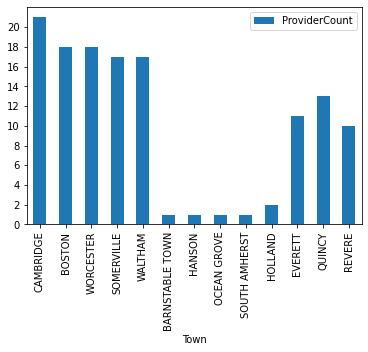

In [7]:
five_most_providers = dict(sorted(num_providers_dict.items(), key=lambda item: item[1], reverse=True)[:5])
five_least_providers = dict(sorted(num_providers_dict.items(), key=lambda item: item[1])[:5])
everett_providers = {'EVERETT': num_providers_dict.get('EVERETT')}
quincy_providers = {'QUINCY': num_providers_dict.get('QUINCY')}
revere_providers = {'REVERE': num_providers_dict.get('REVERE')}
plot_providers = {**five_most_providers, **five_least_providers, **everett_providers, **quincy_providers, **revere_providers}
df_plot_providers = pd.DataFrame(plot_providers.items(), columns=['Town', 'ProviderCount'])

y_max_tick = max(plot_providers.values())

print(df_plot_providers)
df_plot_providers.plot(x='Town', y='ProviderCount', kind='bar')
plt.yticks(np.arange(0, y_max_tick, 2))
plt.show()

## MaxAdDown

   MaxAdDown            Town
0     1000.0       WESTFIELD
1     1000.0  AMHERST CENTER
2      500.0          WOBURN
3      500.0      WINCHESTER
4      500.0       WELLESLEY
5      500.0  WATERTOWN TOWN
6      500.0         WALTHAM
7      500.0        STONEHAM
8      500.0      SOMERVILLE
9      500.0          SAUGUS


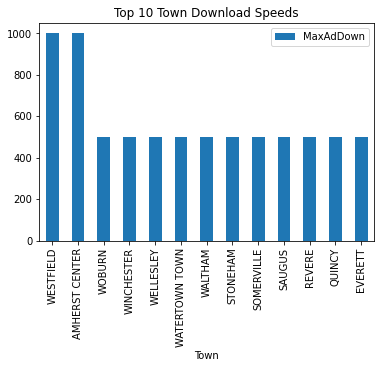

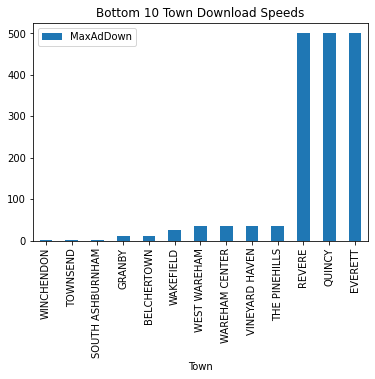

In [8]:
qryStr4 = "SELECT DISTINCT t1.MaxAdDown, t2.town as Town FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town GROUP BY t2.town ORDER BY MaxAdDown DESC"
df_filtered_max_down = pd.read_sql_query(qryStr4, conn)
print(df_filtered_max_down.head(10))

top_ten = df_filtered_max_down.nlargest(10, ['MaxAdDown'])
bottom_ten = df_filtered_max_down.nsmallest(10, ['MaxAdDown'])
revere = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'REVERE']
quincy = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'QUINCY']
everett = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'EVERETT']

combined_max_down_top = pd.concat([top_ten, revere, quincy, everett], axis=0)
combined_max_down_top = combined_max_down_top.reset_index(drop=True)
combined_max_down_bottom = pd.concat([bottom_ten, revere, quincy, everett], axis=0)
combined_max_down_bottom = combined_max_down_bottom.reset_index(drop=True)

combined_max_down_top.plot(x='Town', y='MaxAdDown', kind='bar', title = "Top 10 Town Download Speeds")
plt.show()

combined_max_down_bottom.plot(x='Town', y='MaxAdDown', kind='bar', title = "Bottom 10 Town Download Speeds")
plt.show()

## MaxAdUp

   MaxAdUp            Town
0   1000.0       WESTFIELD
1   1000.0  AMHERST CENTER
2    150.0    WEST CONCORD
3     20.0          WOBURN
4     20.0      WINCHESTER
5     20.0       WELLESLEY
6     20.0  WATERTOWN TOWN
7     20.0         WALTHAM
8     20.0        STONEHAM
9     20.0      SOMERVILLE


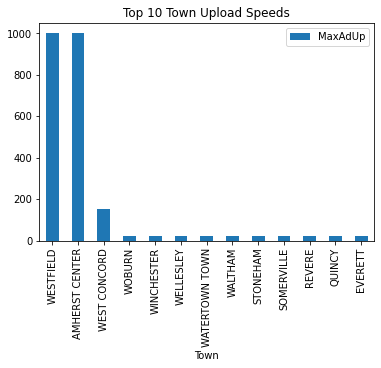

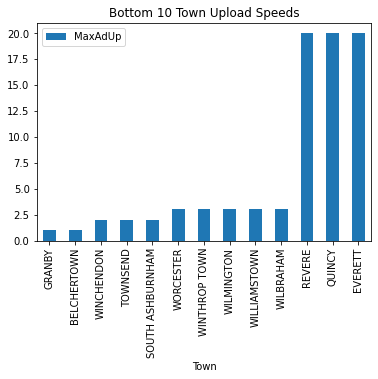

In [9]:
qryStr5 = "SELECT DISTINCT t1.MaxAdUp, t2.town as Town FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town GROUP BY t2.town ORDER BY MaxAdUp DESC"
df_filtered_max_up = pd.read_sql_query(qryStr5, conn)
print(df_filtered_max_up.head(10))

top_ten = df_filtered_max_up.nlargest(10, ['MaxAdUp'])
bottom_ten = df_filtered_max_up.nsmallest(10, ['MaxAdUp'])
revere = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'REVERE']
quincy = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'QUINCY']
everett = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'EVERETT']

combined_max_up_top = pd.concat([top_ten, revere, quincy, everett], axis=0)
combined_max_up_top = combined_max_up_top.reset_index(drop=True)
combined_max_up_bottom = pd.concat([bottom_ten, revere, quincy, everett], axis=0)
combined_max_up_bottom = combined_max_up_bottom.reset_index(drop=True)

combined_max_up_top.plot(x='Town', y='MaxAdUp', kind='bar', title = "Top 10 Town Upload Speeds")
plt.show()

combined_max_up_bottom.plot(x='Town', y='MaxAdUp', kind='bar', title = "Bottom 10 Town Upload Speeds")
plt.show()

## Median Income  (Census Tracks)

In [10]:
qryStr6 = "SELECT t2.Town as Town, AVG(t1.mhi) as 'Average Median Income' FROM median_income_t t1, censusblocks_t t2 WHERE t2.blockcode = t1.ct10_id and t1.mhi > 1 GROUP BY t2.Town;"
town_median_income  = pd.read_sql_query(qryStr6, conn)
town_median_income

,Town,Average Median Income
0,ABINGTON,89531.333333
1,ACUSHNET CENTER,69091.500000
2,ADAMS,50431.000000
3,AGAWAM TOWN,70442.500000
4,AMESBURY TOWN,83022.250000
...,...,...
181,WINCHENDON,74986.000000
182,WINCHESTER,160758.800000
183,WINTHROP TOWN,73106.200000
184,WOBURN,87139.285714


In [11]:
town_median_income.sort_values(by=['Average Median Income'])
top_five_towns = town_median_income.nlargest(5, ['Average Median Income'])
bottom_five_towns = town_median_income.nsmallest(5, ['Average Median Income'])
revere = town_median_income.loc[town_median_income['Town'] == 'REVERE']
quincy = town_median_income.loc[town_median_income['Town'] == 'QUINCY']
everett = town_median_income.loc[town_median_income['Town'] == 'EVERETT']
combined_median_income_df = pd.concat([top_five_towns, bottom_five_towns, revere, quincy, everett], axis=0)
combined_median_income_df = combined_median_income_df.reset_index(drop=True)
combined_median_income_df

,Town,Average Median Income
0,DOVER,224784.000000
1,WELLESLEY,191841.500000
2,BOXFORD,174340.000000
3,LEXINGTON,174233.166667
4,HOPKINTON,167733.500000
5,SPRINGFIELD,38017.162162
6,NORTH ADAMS,38142.500000
7,LAWRENCE,39653.166667
8,HOLYOKE,40761.636364
9,FALL RIVER,43967.920000


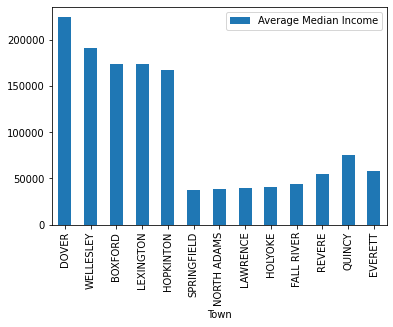

In [12]:
combined_median_income_df.plot(x='Town', y='Average Median Income', kind='bar') 
plt.show()

In [13]:
qryStr7 = "SELECT t2.Town as Town, ROUND(AVG(t1.MaxAdDown),2) as AverageMaxDown, ROUND(AVG(t1.MaxAdUp),2) as AverageMaxUp FROM fcc_data_t t1, censusblocks_t t2 WHERE  substr(t1.BlockCode,0,12) = t2.blockcode AND (t1.MaxAdDown > 0 AND t1.MaxAdUp > 0) GROUP BY t2.TOWN"
town_average_speeds  = pd.read_sql_query(qryStr7, conn)
town_average_speeds

,Town,AverageMaxDown,AverageMaxUp
0,ABINGTON,316.49,141.37
1,ACUSHNET CENTER,207.52,30.63
2,ADAMS,216.09,9.17
3,AGAWAM TOWN,188.94,7.52
4,AMESBURY TOWN,178.74,7.03
...,...,...,...
183,WINCHENDON,143.58,5.82
184,WINCHESTER,328.73,146.88
185,WINTHROP TOWN,212.94,8.20
186,WOBURN,357.69,117.77


In [14]:
dover = town_average_speeds.loc[town_average_speeds['Town'] == 'DOVER']
wellesley = town_average_speeds.loc[town_average_speeds['Town'] == 'WELLESLEY']
boxford = town_average_speeds.loc[town_average_speeds['Town'] == 'BOXFORD']
lexington = town_average_speeds.loc[town_average_speeds['Town'] == 'LEXINGTON']
hopkinton = town_average_speeds.loc[town_average_speeds['Town'] == 'HOPKINTON']
springfield = town_average_speeds.loc[town_average_speeds['Town'] == 'SPRINGFIELD']
north_adams = town_average_speeds.loc[town_average_speeds['Town'] == 'NORTH ADAMS']
lawrence = town_average_speeds.loc[town_average_speeds['Town'] == 'LAWRENCE']
holyoke = town_average_speeds.loc[town_average_speeds['Town'] == 'HOLYOKE']
fall_river = town_average_speeds.loc[town_average_speeds['Town'] == 'FALL RIVER']
revere = town_average_speeds.loc[town_average_speeds['Town'] == 'REVERE']
quincy = town_average_speeds.loc[town_average_speeds['Town'] == 'QUINCY']
everett = town_average_speeds.loc[town_average_speeds['Town'] == 'EVERETT']

combined_average_speed_df = pd.concat([dover, wellesley, boxford, lexington, hopkinton, springfield, north_adams, lawrence, holyoke, fall_river, revere, quincy, everett], axis=0)
combined_average_speed_df = combined_average_speed_df.reset_index(drop=True)
combined_average_speed_df

,Town,AverageMaxDown,AverageMaxUp
0,DOVER,322.58,140.98
1,WELLESLEY,322.43,141.99
2,BOXFORD,286.46,122.86
3,LEXINGTON,353.73,115.81
4,HOPKINTON,322.86,143.56
5,SPRINGFIELD,188.51,7.40
6,NORTH ADAMS,226.23,10.00
7,LAWRENCE,313.94,139.31
8,HOLYOKE,173.91,6.89
9,FALL RIVER,186.09,7.42


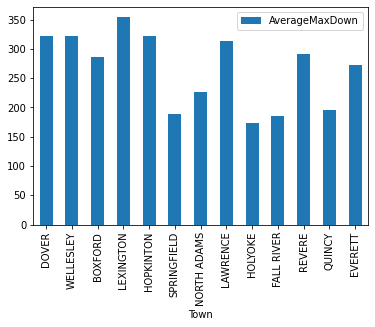

In [15]:
combined_average_speed_df.plot(x='Town', y='AverageMaxDown', kind='bar') 
plt.show()

# add Average Max Up

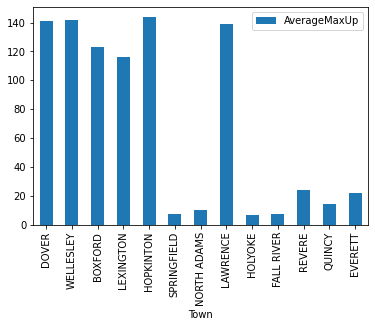

In [16]:
combined_average_speed_df.plot(x='Town', y='AverageMaxUp', kind='bar') 
plt.show()

In [17]:
median_income_and_speed_df = combined_average_speed_df
median_income_and_speed_df['Average Median Income'] = combined_median_income_df['Average Median Income']
median_income_and_speed_df

,Town,AverageMaxDown,AverageMaxUp,Average Median Income
0,DOVER,322.58,140.98,224784.000000
1,WELLESLEY,322.43,141.99,191841.500000
2,BOXFORD,286.46,122.86,174340.000000
3,LEXINGTON,353.73,115.81,174233.166667
4,HOPKINTON,322.86,143.56,167733.500000
5,SPRINGFIELD,188.51,7.40,38017.162162
6,NORTH ADAMS,226.23,10.00,38142.500000
7,LAWRENCE,313.94,139.31,39653.166667
8,HOLYOKE,173.91,6.89,40761.636364
9,FALL RIVER,186.09,7.42,43967.920000


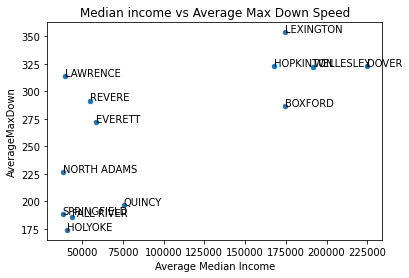

In [18]:
ax1 = median_income_and_speed_df.plot(kind='scatter', x='Average Median Income', y='AverageMaxDown', title='Median income vs Average Max Down Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df.iterrows():
    ax1.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxDown']))

plt.show()


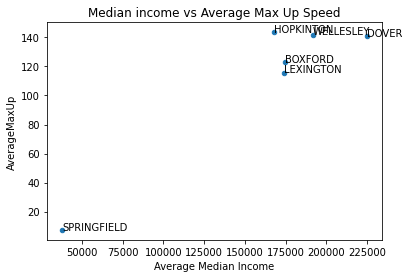

In [19]:
ax2 = median_income_and_speed_df[:6].plot(kind='scatter', x='Average Median Income', y='AverageMaxUp', title='Median income vs Average Max Up Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df[:6].iterrows():
    ax2.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxUp']))

plt.show()

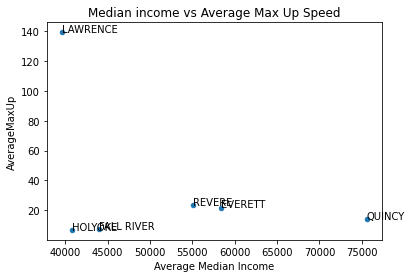

In [20]:
ax3 = median_income_and_speed_df[7:].plot(kind='scatter', x='Average Median Income', y='AverageMaxUp', title='Median income vs Average Max Up Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df[7:].iterrows():
    ax3.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxUp']))

plt.show()

In [21]:
qryStr6 ="SELECT t2.Town as Town, ROUND(AVG(t1.MaxAdDown),2) as AverageMaxDown, ROUND(AVG(t1.MaxAdUp),2) as AverageMaxUp,ROUND(AVG(t3.nh_p),2) as nh_p, ROUND(AVG(t3.nhwhi_p),2) as nhwhi_p,ROUND(AVG(t3.nhaa_p),2) as nhaa_p, ROUND(AVG(t3.nhna_p),2) as nhna_p,ROUND(AVG(t3.nhas_p),2) as nhas_p, ROUND(AVG(t3.nhpi_p),2) as nhpi_p,ROUND(AVG(t3.nhoth_p),2) as nhoth_p, ROUND(AVG(t3.nhmlt_p),2) as nhmlt_p,ROUND(AVG(t3.lat_p),2) as lat_p FROM fcc_data_t t1, censusblocks_t t2, race_ethnicity_t t3 WHERE substr(t1.BlockCode,0,12) = t2.blockcode  AND (t1.MaxAdDown > 0 AND t1.MaxAdUp > 0) AND t2.blockcode = t3.ct10_id GROUP BY t2.TOWN"
df_averages_percentage = pd.read_sql_query(qryStr6, conn)
print(df_averages_percentage.head(10))



              Town  AverageMaxDown  AverageMaxUp   nh_p  nhwhi_p  nhaa_p  \
0         ABINGTON          316.49        141.37  97.81    88.89    1.52   
1  ACUSHNET CENTER          207.52         30.63  95.95    88.68    0.11   
2            ADAMS          216.09          9.17  98.89    96.31    0.68   
3      AGAWAM TOWN          188.94          7.52  94.40    89.28    1.78   
4    AMESBURY TOWN          178.74          7.03  97.32    92.45    0.63   
5   AMHERST CENTER          172.43          7.37  93.46    71.55    5.89   
6          ANDOVER          273.03        119.54  96.63    80.41    3.22   
7        ARLINGTON          394.22        123.11  95.01    76.77    2.69   
8            ATHOL          247.04          9.72  95.07    91.44    0.49   
9        ATTLEBORO          194.69          8.92  92.25    82.03    3.25   

   nhna_p  nhas_p  nhpi_p  nhoth_p  nhmlt_p  lat_p  
0    0.00    3.89    0.00     0.98     2.54   2.19  
1    0.00    1.43    0.00     2.65     3.09   4.05  
2   

In [22]:
df_averages_percentage = df_averages_percentage.rename(columns={"nh_p":"Non-Hispanic","nhwhi_p": "Non-Hispanic White",
                                      "nhaa_p":"Non-Hispanic Black or African American","nhna_p": "Non-Hispanic American Indian and Alaska Native",
                                      "nhas_p":"Non-Hispanic Asian","nhpi_p": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
                                      "nhoth_p":"Non-Hispanic Some Other Races","nhmlt_p": "Non-Hispanic Two or More Races",
                                      "lat_p":"Hispanic/Latino"})

In [23]:
# df_averages_percentage.to_csv('MaxSpeed_Race.csv',index = False)

In [24]:
df_averages_percentage

,Town,AverageMaxDown,AverageMaxUp,Non-Hispanic,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian and Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian/Other Pacific Islander,Non-Hispanic Some Other Races,Non-Hispanic Two or More Races,Hispanic/Latino
0,ABINGTON,316.49,141.37,97.81,88.89,1.52,0.00,3.89,0.00,0.98,2.54,2.19
1,ACUSHNET CENTER,207.52,30.63,95.95,88.68,0.11,0.00,1.43,0.00,2.65,3.09,4.05
2,ADAMS,216.09,9.17,98.89,96.31,0.68,0.04,0.63,0.00,0.12,1.10,1.11
3,AGAWAM TOWN,188.94,7.52,94.40,89.28,1.78,0.02,2.04,0.00,0.00,1.27,5.60
4,AMESBURY TOWN,178.74,7.03,97.32,92.45,0.63,0.09,0.89,0.00,0.15,3.11,2.68
...,...,...,...,...,...,...,...,...,...,...,...,...
183,WINCHENDON,143.58,5.82,97.02,93.09,0.83,0.00,1.00,0.00,0.00,2.09,2.98
184,WINCHESTER,328.73,146.88,98.00,82.48,0.29,0.00,12.12,0.00,0.97,2.14,2.00
185,WINTHROP TOWN,212.94,8.20,91.27,87.89,1.20,0.00,0.61,0.00,0.20,1.37,8.73
186,WOBURN,357.69,117.77,94.81,76.50,6.70,0.00,8.17,0.00,1.69,1.75,5.19


In [25]:
df = df_averages_percentage[['Non-Hispanic Asian','AverageMaxDown']]

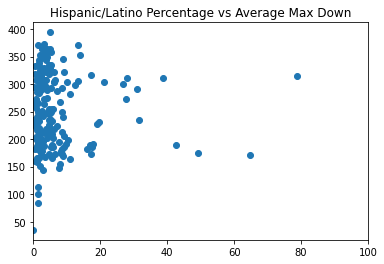

In [36]:
plt.xlim(0,100)
plt.title('Hispanic/Latino Percentage vs Average Max Down')
plt.scatter(df_averages_percentage['Hispanic/Latino'], df_averages_percentage['AverageMaxDown'])
plt.show()

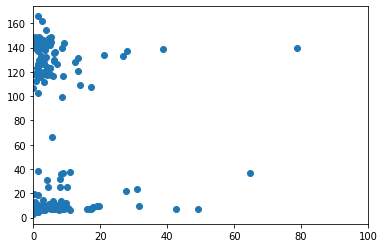

In [27]:
plt.xlim(0,100)
plt.title('Hispanic/Latino Percentage vs Average Max Up')
plt.scatter(df_averages_percentage['Hispanic/Latino'], df_averages_percentage['AverageMaxUp'])
plt.show()

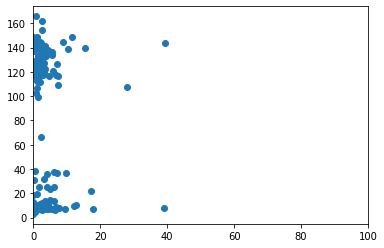

In [28]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic Black or African American'], df_averages_percentage['AverageMaxUp'])
plt.show()

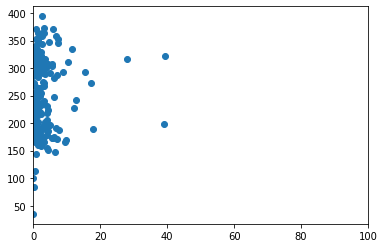

In [29]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic Black or African American'], df_averages_percentage['AverageMaxDown'])
plt.show()

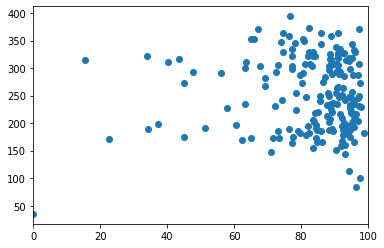

In [30]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic White'], df_averages_percentage['AverageMaxDown'])
plt.show()

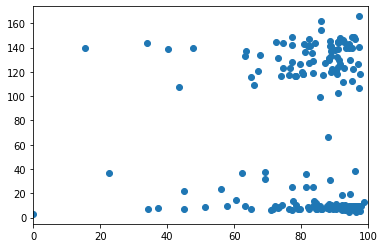

In [31]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic White'], df_averages_percentage['AverageMaxUp'])
plt.show()

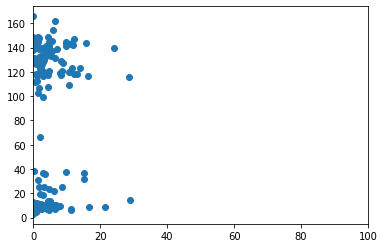

In [32]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic Asian'], df_averages_percentage['AverageMaxUp'])
plt.show()

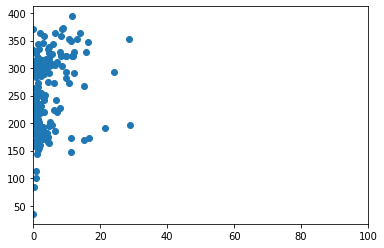

In [33]:
plt.xlim(0,100)
plt.scatter(df_averages_percentage['Non-Hispanic Asian'], df_averages_percentage['AverageMaxDown'])
plt.show()

In [34]:
l1 = df_num_providers['Town'].to_list()
l2 = df_averages_percentage['Town'].to_list()

In [35]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))